In [1]:
!pip install category_encoders shap

In [0]:
history_location = '../data/lending-club-subset.csv'
current_location = '../data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

# # For Google Colab, uncomment:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [0]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [0]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month


In [0]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [0]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [7]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [8]:
# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [0]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [10]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [11]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.669638	validation_1-auc:0.672822
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.670802	validation_1-auc:0.674118
[2]	validation_0-auc:0.676142	validation_1-auc:0.680087
[3]	validation_0-auc:0.679771	validation_1-auc:0.683186
[4]	validation_0-auc:0.682482	validation_1-auc:0.684256
[5]	validation_0-auc:0.683905	validation_1-auc:0.685868
[6]	validation_0-auc:0.685104	validation_1-auc:0.687372
[7]	validation_0-auc:0.685857	validation_1-auc:0.687737
[8]	validation_0-auc:0.685805	validation_1-auc:0.687888
[9]	validation_0-auc:0.686504	validation_1-auc:0.689168
[10]	validation_0-auc:0.686866	validation_1-auc:0.689461
[11]	validation_0-auc:0.686938	validation_1-auc:0.689288
[12]	validation_0-auc:0.687537	validation_1-auc:0.69022
[13]	validation_0-auc:0.688371	validation_1-auc:0.690954
[14]	validation_0-auc:0.688811	validation_1-auc:0.691599

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

 ### Probability Calibration and Expected Value Calculations

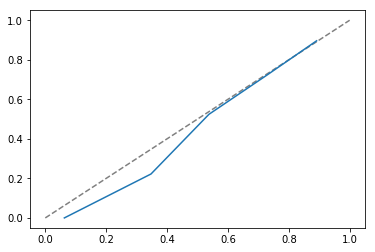

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

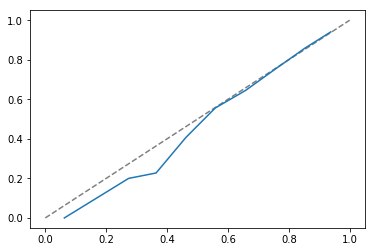

In [13]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

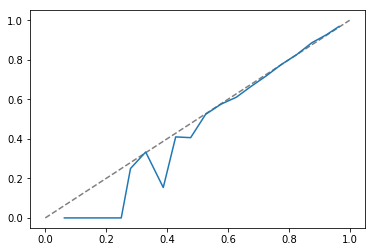

In [14]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [0]:
# Expected value calculations
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val2 = get_results(result_val, y_val, y_pred_proba)

In [16]:
result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [17]:
result_val.describe()

,id,percent_paid
count,2.000000e+04,20000.000000
mean,5.959835e+07,1.041970
std,3.961624e+07,0.267876
min,1.336850e+05,0.000000
25%,2.274274e+07,1.044298
50%,6.136165e+07,1.113421
75%,8.869767e+07,1.182077
max,1.493697e+08,1.599994


In [0]:
%matplotlib inline
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(df, n_picks=40, n_sims=10000, 
             grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01', 
             min_expected_value=-25):
    """
    What if you picked random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start_date) &
                 (df['issue_d'] <= end_date) & 
                 (df['expected_value'] >= min_expected_value))
    possible = df[condition]
    
    simulations = []
    for _ in tnrange(n_sims):
        picks = possible.sample(n_picks).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    print(f'#### {n_picks} loans picked from {len(possible)} possible loans')
    print(f'- Dates: {start_date}-{end_date}\n' + 
                     f'- Grades: {grades}\n' +
                     f'- Expected Value >= {min_expected_value}')
    print(f'#### Range of results from {n_sims} simulations')
    print(simulations.describe().to_string())
    plt.title(f'{percent}% of simulations did not profit.')


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 28.10330103009939
#### Range of results from 10000 simulations
count    10000.000000
mean      1098.993057
std         34.395905
min        928.245578
25%       1076.614440
50%       1100.909941
75%       1123.287377
max       1206.032406


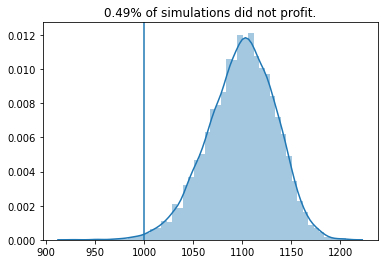

In [19]:
import numpy as np
min_expected_value = np.percentile(result_val2['expected_value'], 80)
simulate(result_val2, min_expected_value=min_expected_value)

In [20]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.709825059932263



#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 28.10353728312254
#### Range of results from 10000 simulations
count    10000.000000
mean      1093.169538
std         35.649110
min        942.541626
25%       1070.226650
50%       1094.997169
75%       1118.406071
max       1197.661660


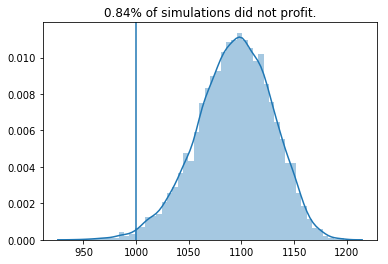

In [21]:
#test
result_test = get_results(result_test, y_test, y_pred_proba)
min_expected_value = np.percentile(result_test['expected_value'], 80)
simulate(result_test, min_expected_value=min_expected_value)

## Explain decisions with shapley value plots

In [39]:
df = result_test.copy()
condition = (df['expected_value'] >= min_expected_value)
possible = df[condition]
picks = possible.sample(40, random_state=42).copy()
picks

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
106384,17804482.0,2014-06-01,B,1.190049,36,11.67,Fully Paid,0.915435,35.01,33.7525,-25,28.784068
110718,3196477.0,2013-01-01,D,1.332754,36,19.72,Fully Paid,0.826032,59.16,39.7900,-25,28.518593
124703,65282213.0,2015-11-01,C,1.013939,60,12.59,Fully Paid,0.824601,62.95,40.7375,-25,29.207200
2477,383777.0,2009-03-01,B,1.019927,36,11.89,Fully Paid,0.908779,35.67,33.9175,-25,28.542992
1104,6328662.0,2013-07-01,B,1.287734,60,11.55,Fully Paid,0.868784,57.75,39.4375,-25,30.982250
49571,1675962.0,2012-11-01,B,1.105050,36,10.16,Fully Paid,0.926388,30.48,32.6200,-25,28.378457
67183,7695294.0,2013-11-01,C,1.183398,60,14.30,Fully Paid,0.835548,71.50,42.8750,-25,31.712795
81982,125384326.0,2017-12-01,A,1.017289,36,7.35,Fully Paid,0.964830,22.05,30.5125,-25,28.560111
126315,144826391.0,2018-12-01,D,1.015443,36,17.97,Fully Paid,0.863518,53.91,38.4775,-25,29.813945
40826,8956766.0,2013-11-01,A,1.094453,36,8.90,Fully Paid,0.947780,26.70,31.6750,-25,28.715429


In [50]:
data_for_prediction = X_test[X_test.index==120364]
data_for_prediction

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_title_owner,fico_range_high,funded_amnt,home_ownership,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_open_acc,sec_app_open_act_il,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
120364,2.0,NY,14.0,107000.0,156500.0,28497.0,26500.0,0.0,0.0,0.0,True,9.16,6.65,4810,1.0,False,19.0,False,False,819.0,4000.0,MORTGAGE,0.0,0.0,120.46,5.32,9,2017,4000.0,0.0,149.0,158.0,1.0,3.0,True,NaN,1.0,NaN,0.0,0.0,2.0,0.0,False,False,2.0,100.0,0.0,0.0,other,0.0,0.0,5114.0,774.0,3.0,1.0,1,36 months,5.0,False,0.0,244246.0,17.0,9185.0,26500.0,3.0,26500.0


In [0]:
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns

In [52]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

In [58]:
#wrong Prediction

data_for_prediction = X_test[X_test.index==120043]
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)